In [44]:
# download sample nf2 file
import urllib.request

nf2_sample_path = 'sample.nf2'
urllib.request.urlretrieve("https://g-66affc.7a577b.6fbd.data.globus.org/nf2_series/20240507_172400_TAI.nf2", nf2_sample_path)

('sample.nf2', <http.client.HTTPMessage at 0x2de0046a0>)

In [45]:
from nf2.evaluation.output import CartesianOutput

nf2_model = CartesianOutput(nf2_sample_path)

/Users/rjarolim/PycharmProjects/NF2/nf2/evaluation/output.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.state = torch.load(checkpoint, map_location=device)


In [46]:
# list all available metrics
from nf2.evaluation.output_metrics import metric_mapping

print(f"{'Metrics':<20}")
print(f"{'-'*20}")
for metric in metric_mapping:
    print(f"{metric:<20}")
    

Metrics             
--------------------
j                   
b_nabla_bz          
alpha               
spherical_energy_gradient
energy_gradient     
magnetic_helicity   
los_trv_azi         
free_energy         
squashing_factor    


In [47]:
nf2_out = nf2_model.load_cube(height_range=[0, 20], Mm_per_pixel=0.72, metrics=['j'], progress=True)

Load NF2: 100%|██████████| 1094/1094 [03:40<00:00,  4.95it/s]


In [48]:
import numpy as np

# print all keys and subkeys
print(f"{'Keys':<20}{'Values':<20}")
print(f"{'-'*20}{'-'*20}")
for key in nf2_out.keys():
    if isinstance(nf2_out[key], dict):
        print(f"{key:<20}{list(nf2_out[key].keys())}")
    elif isinstance(nf2_out[key], np.ndarray):
        print(f"{key:<20}{nf2_out[key].shape}")
    elif isinstance(nf2_out[key], float):
        print(f"{key:<20}{nf2_out[key]:.2f}")
    else:
        print(f"{key:<20}")

Keys                Values              
----------------------------------------
b                   (601, 257, 29, 3)
a                   (601, 257, 29, 3)
jac_matrix          (601, 257, 29, 3, 3)
metrics             ['j']
coords              (601, 257, 29, 3)
Mm_per_pixel        0.72


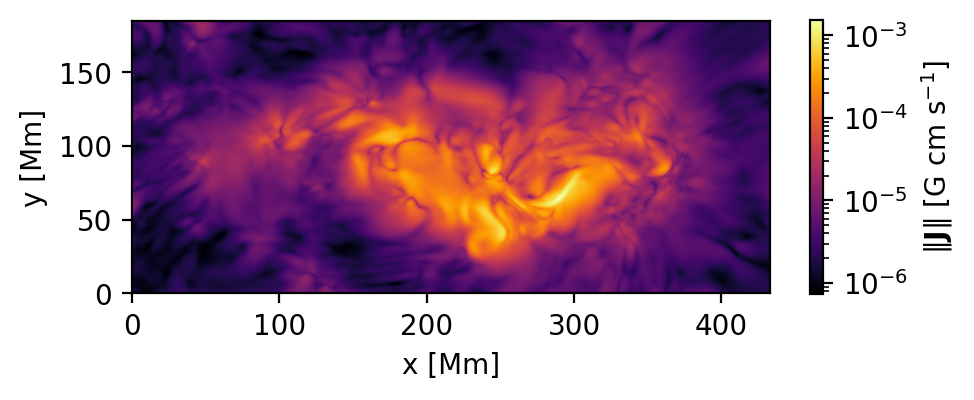

In [49]:
# plot integrated current density
from matplotlib import pyplot as plt
from astropy import units as u

cm_per_pixel = nf2_out['Mm_per_pixel'] * 1e-8
current_density = np.linalg.norm(nf2_out['metrics']['j'], axis=-1)
integrated_current_density = current_density.sum(axis=2).to_value(u.G  / u.s) * cm_per_pixel

extent = [0, integrated_current_density.shape[0] * nf2_out['Mm_per_pixel'], 0, 
          integrated_current_density.shape[1] * nf2_out['Mm_per_pixel']]

fig, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=200)

im = ax.imshow(integrated_current_density.T, cmap='inferno', origin='lower', extent=extent, norm='log')

plt.colorbar(im, ax=ax, label=r'$\Vert \mathbf{J} \Vert$ [G cm s$^{-1}$]')
ax.set_xlabel("x [Mm]")
ax.set_ylabel("y [Mm]")
plt.tight_layout()
plt.show()